# Part 1: Representations

In this part of the assignment, you consider synthetic data that cannot be accurately classified with standard logistic regression. Instead, you will show how a different representation can be used to effectively classify the data, and that a neural network (specifically a multilayer perceptron) can automatically learn such a representation directly from the original data.

**Learning objectives.** You will:
1. Reason about separability, decision boundaries, and data representations.
2. Use a multilayer perceptron to show that a neural network can automatically learn a helpful data representation for classification.
3. Understand the concept of overfitting and its relationship to model complexity.
4. Learn about early stopping as a regularization technique.
<!-- 3. Perform an ablation study for the learning rate hyperparameter for training a neural network. -->

**What is a representation?** A *representation* is a transformation of the input features that captures relevant patterns for a machine learning task. For example, instead of using raw pixel values, we might represent an image by its edges, shapes, or textures. Good representations make patterns more easily separable, while poor representations can make even simple patterns difficult to detect. In this assignment, you'll see how manual feature engineering (creating representations by hand) compares to automatic representation learning (letting neural networks discover useful representations).

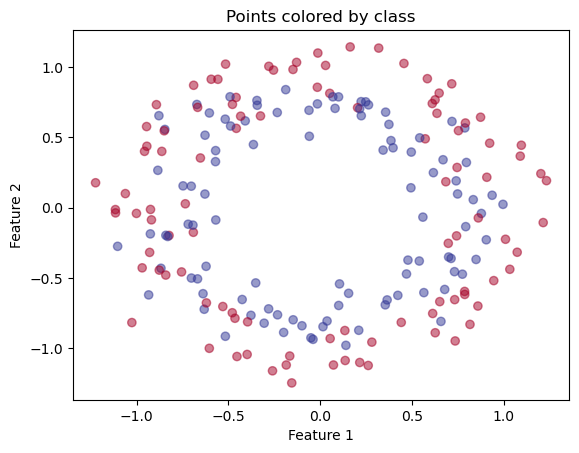

In [2]:
# Run but DO NOT MODIFY this code

# Import libraries
import numpy as np
from sklearn.datasets import make_circles
from matplotlib import pyplot as plt

# Set random seed for reproducibility
np.random.seed(2025)

# Generate the dataset
X, y = make_circles(n_samples=200, noise=0.14, random_state=2025)

ax = plt.subplot()
ax.set_title("Points colored by class")
ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, cmap=plt.cm.RdYlBu)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

In [3]:
# Run but DO NOT MODIFY this code
# In later tasks you will call the plot_decision_boundary 
# function to help visualize learned models geometrically in
# the original 2D feature space plotted above.

def plot_decision_boundary(X, y, model):
    """
    Plot decision boundary for a 2D dataset
    """
    plt.figure(figsize=(8, 6))
    
    # Create a mesh
    h = 0.01
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Make predictions on the mesh
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(mesh_points)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and data points
    plt.contourf(xx, yy, Z, levels=1, alpha=0.3, colors=['red', 'blue'])
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.colorbar(scatter)
    plt.show()

## Task 1

For this task, you can use the same data for training and evaluating. We will only focus on whether we can fit the pattern in the data.

1. Build a [logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#logisticregression) to predict the value of `y` (either `0` or `1`) as a function of the two features (columns) in the design matrix `X`. Use the parameter settings `penalty=None` and `random_state=2025` (this will train a basic model without applying any regularization). 

2. Visualize the decision boundary of your model using the provided `plot_decision_boundary` function. The function expects `X`, `y`, and your fit model as inputs. Recall that the decision boundary is the threshold (in feature space) between which a classification model predicts one class or another.

3. Evaluate the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) of your model's predictions compared to the true `y`. Report your results and **briefly explain why the accuracy is so low**, referring both to the visualization and to how logistic regression works.

**Note:** For a binary classification problem with balanced classes, random guessing would achieve approximately 50% accuracy. Accuracy near 50% should be considered poor performance in general.

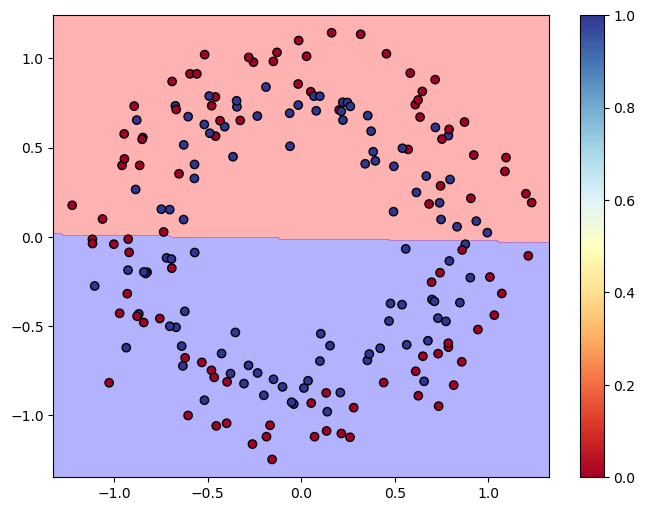

The Logistic Regression model accuracy is 0.505


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Write code for task 1 here

logistic_regression_model = LogisticRegression(penalty = None, random_state = 2025)
logistic_regression_model.fit(X, y)
y_prediction = logistic_regression_model.predict(X)
plot_decision_boundary(X, y, logistic_regression_model)
logistic_regression_accuracy = accuracy_score(y, y_prediction)
print("The Logistic Regression model accuracy is", logistic_regression_accuracy)

Based on my results, I find that the accuracy is 0.505, meaning that our model is currently just slightly better than random guessing. Looking at the visualization, it appears that the data here is non-linearly separable since the data forms into a circular pattern. The main problem is that logistic regression can only learn linear decision boundaries since it tries to split the data with just a straight line. But the visualization clearly shows that a linear boundary cannot really separate circles. Thus, there are many data points that are misclassified, which could contribute to the low accuracy score.  

## Task 2

For this task, you can use the same data for training and evaluating. We will only focus on whether we can fit the pattern in the data.

Show that there exists a different representation of the data for which logistic regression can classify the data with greater than 70% accuracy. To do so, 

1. Implement the `compute_X_rep` method in the `RepModel` wrapper to compute a new representation of the original `X` data, **without using `y`**. 

2. Once you have implemented `compute_X_rep`, you can create, fit, and predict with a `RepModel` as you normally would for any `sklearn` model object. Note that the `RepModel` wrapper simply uses a [logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#logisticregression) but passes your transformed representation rather than the original input features. 

3. Visualize the decision boundary of your model using the provided `plot_decision_boundary` function. The function expects `X`, `y`, and your fit model as inputs. Recall that the decision boundary is the threshold (in feature space) between which a classification model predicts one class or another. Because your transformed representation might not be linear with respect to the original input features, the decision boundary you see visualized may not be linear. 

4. Evaluate the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) (you should get at least 70%). Report your results and briefly explain why your representation enables logistic regression to accurately classify the data.

**Hints:** 
- Observe from the visualization how one class tends to be closer to the origin (in terms of Euclidean distance) and another farther from the origin. How can you use this to compute a useful representation for classifying the data correctly?
- `sklearn` expects the inputs to be in a design matrix formatted as a 2D NumPy array even if there is only a single feature. If your representation uses a single feature (that is, if `X_rep` is a 1D NumPy array), then `X_rep.reshape(-1, 1)` will transform it into a 2D NumPy array with a single column as expected by the `sklearn` API.

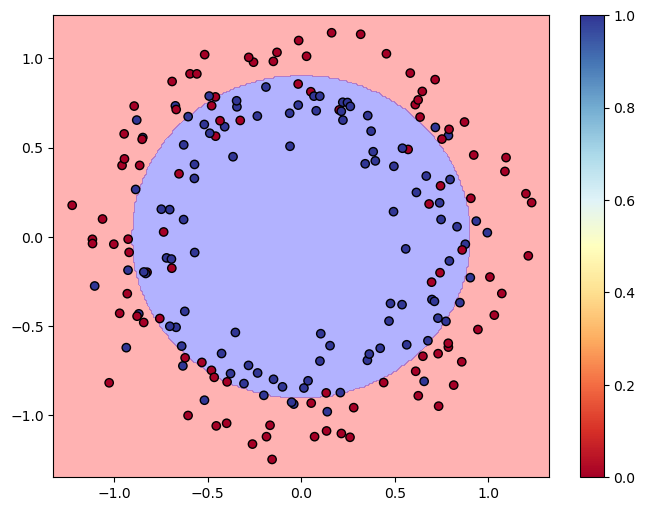

The RepModel accuracy is 0.77


In [8]:
# Write code for task 2 here

# Create a wrapper model that applies the transformation then predicts
# You only need to implement `compute_X_rep`
class RepModel:
    def __init__(self):
        self.model = LogisticRegression(penalty=None, random_state=2025)

    def compute_X_rep(self, X):
        # TODO: Return different representation of X
        distance = np.sqrt((X[:, 0] ** 2) + (X[:, 1] ** 2))
        return distance.reshape(-1, 1)
    
    def predict(self, X):
        X_rep = self.compute_X_rep(X)
        return self.model.predict(X_rep)
    
    def fit(self, X, y):
        X_rep = self.compute_X_rep(X)
        self.model.fit(X_rep, y)

rep_model = RepModel()
rep_model.fit(X, y)
y_prediction_rep_model = rep_model.predict(X)
plot_decision_boundary(X, y, rep_model)
rep_model_accuracy = accuracy_score(y, y_prediction_rep_model)
print("The RepModel accuracy is", rep_model_accuracy)

The accuracy of the RepModel is 0.77, which is already better than the basic logistic regression model in Task 1. It appears that one class forms an inner circle and the other class forms an outer circle based on the visualization. So the two classes do become linearly separable in 1D when we represent each point with its distance from the origin. This allows the logistic regression to correctly classify most of the data points and the distance feature does improve the accuracy score.

## Task 3

For this task, you can use the same data for training and evaluating. We will only focus on whether we can fit the pattern in the data.

The representation in task 2 was (relatively) easy to reason about because our data in this exercise are two-dimensional and synthetic. With real data, it can be incredibly time-consuming to determine a good representation of the data by hand (a process sometimes referred to as "feature engineering").

In this task you will achieve comparable results **without** explicitly computing a different representation of `X` by using a multilayer perceptron to automatically learn a useful representation of the data for classification.

1. Use Scikit-Learn to build a [multilayer perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) classifier for predicting `y` using only `X`, and not any explicitly computed transformation of `X`, as input. Evaluate and report the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) of your model .
    - Use `hidden_layer_sizes=(8,)` to create a network with exactly one hidden layer containing 8 hidden units. The `hidden_layer_sizes` parameter accepts a tuple where each number represents the number of neurons in that hidden layer. For example, `(8,)` means one hidden layer with 8 neurons, while `(10, 5)` would mean two hidden layers with 10 and 5 neurons respectively.
    - Set `random_state=2025` (for reproducibility), `max_iter=2000` (to ensure adequate training time), and `alpha=0.0` (to turn off regularization).

2. Visualize the decision boundary of your model using the provided `plot_decision_boundary` function. The function expects `X`, `y`, and your fit model as inputs. Recall that the decision boundary is the threshold (in feature space) between which a classification model predicts one class or another. Because the neural network automatically learns a nonlinear representation of the data, the decision boundary might not be linear with respect to the original input features. It is likely that the neural network will learn a very similar representation to the one you computed in task 2.

3. Evaluate the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html). You should get at least 70%, similar to the performance in task 2.

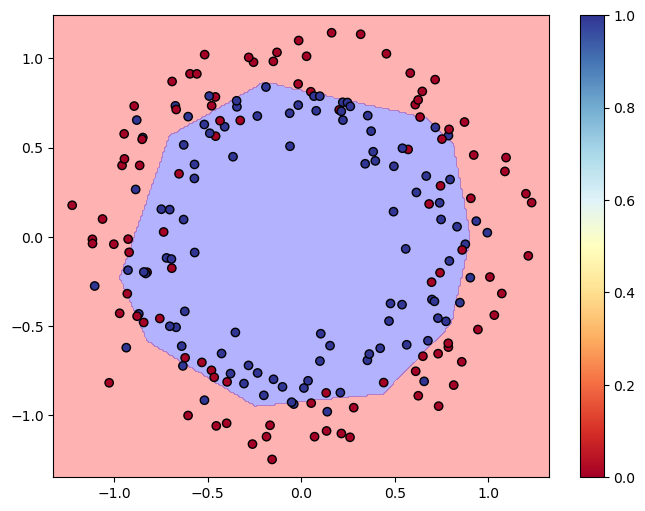

The Multilayer Perceptron Classifier model accuracy is 0.77


In [11]:
from sklearn.neural_network import MLPClassifier
# Write code for task 3 here

multilayer_perceptron_model = MLPClassifier(hidden_layer_sizes = (8,), random_state = 2025, max_iter = 2000, alpha = 0.0)
multilayer_perceptron_model.fit(X, y)
y_prediction_MLP = multilayer_perceptron_model.predict(X)
plot_decision_boundary(X, y, multilayer_perceptron_model)
multilayer_perceptron_accuracy = accuracy_score(y, y_prediction_MLP)
print("The Multilayer Perceptron Classifier model accuracy is", multilayer_perceptron_accuracy)

## Task 4: Model Capacity and Overfitting

Neural networks can be very powerful, but this power comes with a risk: large neural networks can become so complex that they have the model capacity to "memorize" the training data (overfit to small noise) rather than learning generalizable patterns. In this task, you will demonstrate overfitting by comparing two neural networks of very different sizes on the same dataset. 

1. First, split your data into equal sized [train and test sets](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with `test_size=0.5` and `random_state=2025`.

2. Then train two [multilayer perceptrons](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) on the training data.
    - **Small network**: `hidden_layer_sizes=(8,)` (same as Task 3, input --> 8 hidden units --> output).
    - **Large network**: `hidden_layer_sizes=(1000,1000,)` (input --> 1000 hidden units --> another 1000 hidden units --> output). Fitting this model will take substantially longer (from several seconds to about a minute).
    - For both models, set `random_state=2025` (for reproducibility), `max_iter=2000` (to ensure adequate training time), and `alpha=0.0` (to turn off regularization). 

3. Visualize the decision boundary of **both** models using the provided `plot_decision_boundary` function on the training data. The small network should have a decision boundary that looks similar to that from the previous task using the entire dataset. The large network should have a quite complex decision boundary.

4. Evaluate the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) of both models on both the train and the test data (so **report four accuracies in total**). You should observe that the large network significantly overfits compared to the small network.

5. **Briefly explain** how many model parameters the large network has versus how many model parameters the small network has. You can ignore bias terms in your calculations, and ensure that you consider the coefficients connecting input to hidden units, hidden to hidden units (for the large network), and hidden to output units. 
To support your answer, **choose one** of the following methods:
- Present your calculations, or
- Provide the code used to count the parameters.
 

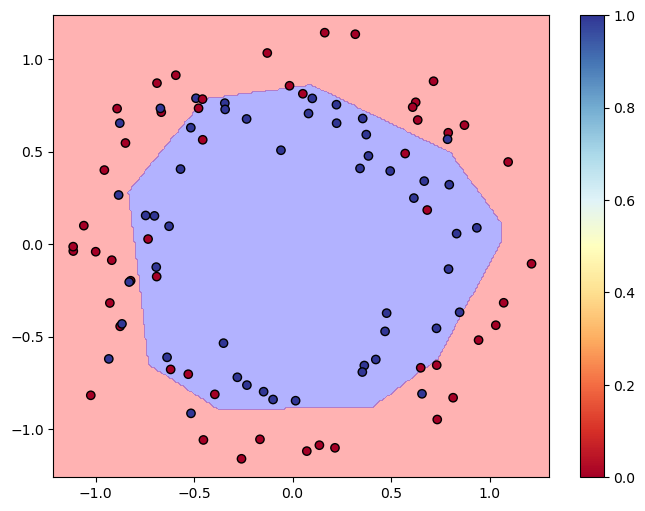

Train accuracy for small network is 0.79
Test accuracy for small network is 0.76


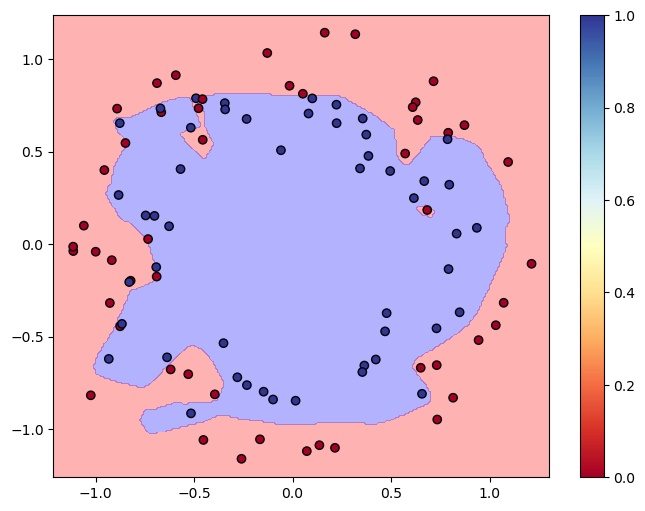

Train accuracy for large network is 0.95
Test accuracy for large network is 0.68
The parameter count for small network is 24
The parameter count for large network is 1003000


In [13]:
from sklearn.model_selection import train_test_split

# Write code for task 4 here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 2025)
small_MLP = MLPClassifier(hidden_layer_sizes = (8,), random_state = 2025, max_iter = 2000, alpha = 0.0)
small_MLP.fit(X_train, y_train)
y_prediction_train_small_MLP = small_MLP.predict(X_train)
y_prediction_test_small_MLP = small_MLP.predict(X_test)
plot_decision_boundary(X_train, y_train, small_MLP)
small_MLP_train_accuracy = accuracy_score(y_train, y_prediction_train_small_MLP)
small_MLP_test_accuracy = accuracy_score(y_test, y_prediction_test_small_MLP)
print("Train accuracy for small network is", small_MLP_train_accuracy)
print("Test accuracy for small network is", small_MLP_test_accuracy)
large_MLP = MLPClassifier(hidden_layer_sizes = (1000, 1000), random_state = 2025, max_iter = 2000, alpha = 0.0)
large_MLP.fit(X_train, y_train)
y_prediction_train_large_MLP = large_MLP.predict(X_train)
y_prediction_test_large_MLP = large_MLP.predict(X_test)
plot_decision_boundary(X_train, y_train, large_MLP)
large_MLP_train_accuracy = accuracy_score(y_train, y_prediction_train_large_MLP)
large_MLP_test_accuracy = accuracy_score(y_test, y_prediction_test_large_MLP)
print("Train accuracy for large network is", large_MLP_train_accuracy)
print("Test accuracy for large network is", large_MLP_test_accuracy)
small_MLP_parameter_count = sum(np.prod(weight.shape) for weight in small_MLP.coefs_)
large_MLP_parameter_count = sum(np.prod(weight.shape) for weight in large_MLP.coefs_)
print("The parameter count for small network is", small_MLP_parameter_count)
print("The parameter count for large network is", large_MLP_parameter_count)

The small network has 24 parameters since there are 16 weights between the input and the hidden layer (2 X 8 = 16), and there are 8 weights between the hidden layer and the output (8 X 1 = 8). Thus, the small network has 24 parameters (16 + 8 = 24).

The large network has 1,003,000 since there are 2,000 weights between the input and the first hidden layer (2 X 1,000 = 2,000), there are 1,000,000 weights between the first hidden layer and the second hidden layer (1,000 X 1,000 = 1,000,000), and there are 1,000 weights between the second hidden layer and the output (1,000 X 1 = 1,000). Thus, the large network has 1,003,000 parameters (2,000 + 1,000,000 + 1,000 = 1,003,000).

## Task 5: Early Stopping to Prevent Overfitting

In Task 4, you observed that the large network significantly overfits compared to the small network. Early stopping is a regularization technique that can help mitigate this overfitting, even in large overparameterized neural networks. It is widely used in practice -- most modern deep learning practitioners use early stopping as a standard regularization technique, as training neural networks to full convergence on the training loss often leads to overfitting.

**How does early stopping work?** Early stopping monitors the model's performance on a validation set during training. When the validation performance stops improving (or starts getting worse) for a specified number of consecutive epochs, training is halted. This prevents the model from continuing to memorize the training data and helps it generalize better to unseen data.

1. Create and train a large network with early stopping using the same train/test split from Task 4. Use [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) with:
  - `hidden_layer_sizes=(1000, 1000)` (same large architecture as Task 4)
  - `early_stopping=True` to enable early stopping
  - `validation_fraction=0.4` to use 40% of training data for validation
  - `n_iter_no_change=10` to stop if validation score doesn't improve for 10 consecutive epochs
  - `random_state=2025`, `max_iter=2000`, and `alpha=0.0` (same as Task 4)

2. Visualize the decision boundary of the model using the provided `plot_decision_boundary` function on the training data. Though the network is just as large, you should see a much simpler decision boundary than before.

3. Evaluate the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) of both models on both the train and the test data (so report two accuracies in total). Then, compare these results to the accuracies of the large network without early stopping from Task 4. You should observe that early stopping significantly reduces the generalization gap of the large network.

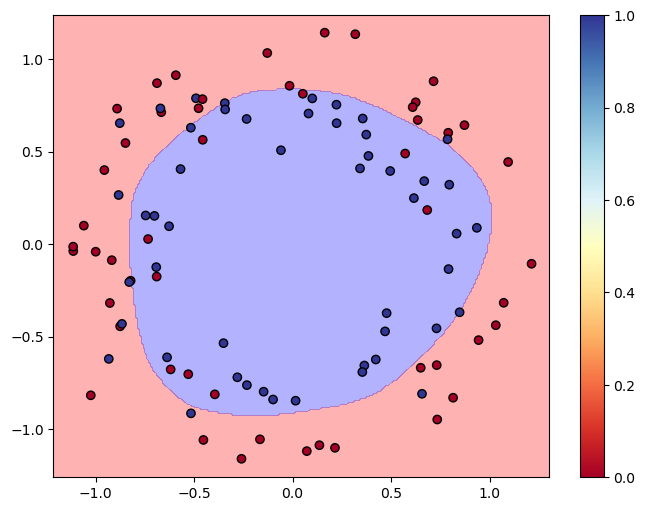

Train accuracy for the large network with early stopping is 0.8
Test accuracy for the large network with early stopping is 0.75
Train accuracy for the large network without early stopping from Task 4 is 0.95
Test accuracy for the large network without early stopping from Task 4 is 0.68


In [16]:
# Write code for task 5 here
early_stopping_MLP = MLPClassifier(hidden_layer_sizes = (1000, 1000), early_stopping = True, validation_fraction = 0.4, n_iter_no_change = 10, random_state = 2025, max_iter = 2000, alpha = 0.0)
early_stopping_MLP.fit(X_train, y_train)
y_prediction_train_early_stopping = early_stopping_MLP.predict(X_train)
y_prediction_test_early_stopping = early_stopping_MLP.predict(X_test)
plot_decision_boundary(X_train, y_train, early_stopping_MLP)
early_stopping_train_accuracy = accuracy_score(y_train, y_prediction_train_early_stopping)
early_stopping_test_accuracy = accuracy_score(y_test, y_prediction_test_early_stopping)
print("Train accuracy for the large network with early stopping is", early_stopping_train_accuracy)
print("Test accuracy for the large network with early stopping is", early_stopping_test_accuracy)
print("Train accuracy for the large network without early stopping from Task 4 is", large_MLP_train_accuracy)
print("Test accuracy for the large network without early stopping from Task 4 is", large_MLP_test_accuracy)